# PPCA in TensorFlow Probability
This is the ZIFA method (Pierson, 2015)

First we import necessary libraries

In [76]:
import functools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd

tf.enable_v2_behavior()

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

We create a function of the ZIFA model:

In [77]:
Root = tfd.JointDistributionCoroutine.Root
def ZIFA(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    
    # We start by generating a sigma^2
    sigma_sqrd = yield Root(tfd.Independent(
        tfd.Normal(loc=stddv_datapoints*tf.ones([data_dim, 1]), scale=0.15, name='sigma')))
    
    # We initialize lambda here
    lamda = yield Root(tfd.Independent(
        tfd.Uniform(low=0.05, high=0.15, name='lambda')))
    
    # Then the latent data z
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=1.0*tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))

#     For A we first define the boundaries for its uniform distribution and then A itself. The boundaries are created outside the function,
#     lower in this cell
    A = yield Root(tfd.Independent(
        tfd.Uniform(low=low_A, high=high_A, name='A')))
    
    # Here comes mu
    mu = yield Root(tfd.Independent(
        tfd.Uniform(low=2.0*tf.ones([data_dim,1]),
                 high=6.5*tf.ones([data_dim,1]),
                 name="mu"), reinterpreted_batch_ndims=1))
    
    # Tensorflows einsum() function is used to take the products of A and the individual columns of z, which is used to obtain the means of x
    x = yield Root(tfd.Independent(tfd.Normal(
        loc=tf.einsum('ij,ki->kj',z,A)+mu,
        scale=sigma_sqrd,
        name="x"), reinterpreted_batch_ndims=2))
    
    # Bernoulli variable h is generated based on x and lambda
    h = yield Root(tfd.Independent(tfd.Bernoulli(
        probs = 1-tf.exp(tf.multiply(-lamda,tf.square(x))), name = 'h',dtype=tf.float32,)))
#     h = h_dist.sample()
    
    # Then the final points y can be generated
    y = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.multiply(h,x),
                 scale=0,
                 name="y"), reinterpreted_batch_ndims=2))
    

num_datapoints = 10000
data_dim = 3
latent_dim = 2
stddv_datapoints = 0.3

# The boundaries for the uniform distribution of A
low_A = np.float32(-0.5*np.ones([data_dim, latent_dim]))
np.fill_diagonal(low_A,0.9*stddv_datapoints)
high_A = np.float32(0.5*np.ones([data_dim, latent_dim]))
np.fill_diagonal(high_A,1.1*stddv_datapoints)

concrete_ZIFA_model = functools.partial(ZIFA,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model = tfd.JointDistributionCoroutine(concrete_ZIFA_model)

And we generate some data. Note the Zero inflation as depicted in the three histograms representing three genes.

Lambda:  0.061301555
mu: [[5.2817383]
 [4.696746 ]
 [3.9292154]]


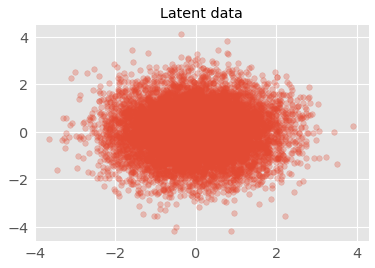

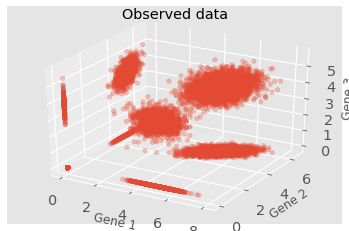

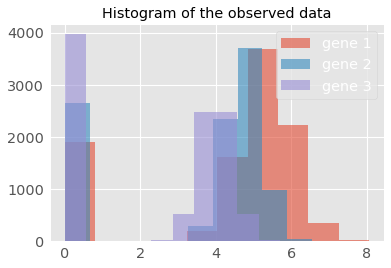

In [78]:
actual_sigma, actual_lambda, actual_z, actual_A, actual_mu, actual_x, actual_h, y_train = model.sample()
print('Lambda: ', actual_lambda.numpy())
print('mu:', actual_mu.numpy())

plt.scatter(actual_z[0,:], actual_z[1,:], alpha=0.3)
title = plt.title('Latent data')
plt.setp(title, color='black') 
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_train[0,:],y_train[1,:],y_train[2,:], alpha=0.3)
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

plt.hist(y_train[0, :], label='gene 1', alpha=0.6)
plt.hist(y_train[1, :], label='gene 2', alpha=0.6)
plt.hist(y_train[2, :], label='gene 3', alpha=0.6)
title = plt.title('Histogram of the observed data')
plt.setp(title, color='black')
plt.legend()
plt.show()

Note: When evaluating the log probabiltiy of an event, we sometimes get 'nan'-values, which is why optimalization is not yet fully functional.

In [79]:
model.log_prob((actual_sigma, actual_lambda, actual_z, actual_A, actual_mu, actual_h, actual_x, y_train))

<tf.Tensor: id=63717, shape=(3,), dtype=float32, numpy=array([nan, nan, nan], dtype=float32)>

Then we minimize the error numerically. According to Pierson (2015), $\mu$ and $A$ should be optimized first, followed by $\sigma^2$ and ending with $\lambda$. We first optimize $\mu$ by initializing it as the mean of our observed data. We then optimalize on a separate model that doesn't contain $\lambda$, followed by the complete model.

In [80]:
def ZIFA_step1(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    
    sigma_sqrd = yield Root(tfd.Independent(
        tfd.Normal(loc=stddv_datapoints*tf.ones([data_dim, 1]), scale=0.05, name='sigma')))
    
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=1.0*tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))

    A = yield Root(tfd.Independent(
        tfd.Uniform(low=low_A, high=high_A, name='A')))
    
    mu = yield Root(tfd.Independent(
        tfd.Uniform(low=2.5*tf.ones([data_dim,1]),
                 high=5.5*tf.ones([data_dim,1]),
                 name="mu"), reinterpreted_batch_ndims=1))
    
    y = yield tfd.Independent(tfd.Normal(
        loc=tf.einsum('ij,ki->kj',z,A)+mu,
        scale=sigma_sqrd,
        name="y"), reinterpreted_batch_ndims=2)
    
    
    
ZIFA_model_1 = functools.partial(ZIFA_step1,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model_1 = tfd.JointDistributionCoroutine(ZIFA_model_1)

Fortunately, this incomplete model is more forviging when evaluating the log probabilities. However, returned 'nan'-values do still occur.

In [81]:
model_1.log_prob((actual_sigma, actual_z, actual_A, actual_mu, y_train))

<tf.Tensor: id=63825, shape=(3,), dtype=float32, numpy=array([-1005970.4, -1005967.7, -1005969.5], dtype=float32)>

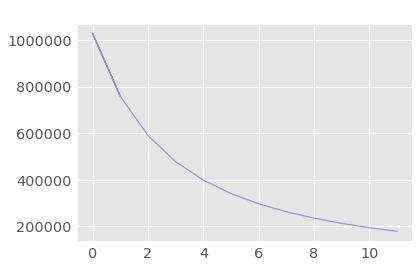

In [82]:
mu = tf.expand_dims(tf.Variable(np.float32(np.sum(y_train, axis=1)/np.sum(y_train!=0, axis=1))),1)
sigma = tf.Variable(0.3*tf.ones([data_dim,1]))
A_np = np.float32(np.zeros([data_dim, latent_dim]))
np.fill_diagonal(A_np,stddv_datapoints)
A = tf.Variable(A_np)
z = tf.Variable(np.zeros([latent_dim, num_datapoints]), dtype=tf.float32)

target_log_prob_fn = lambda sigma, z, A, mu: model_1.log_prob((sigma, z, A, mu, y_train))
losses = tfp.math.minimize(lambda: -target_log_prob_fn(sigma, z, A, mu),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=1000)
plt.plot(losses)
plt.title('Loss function over iterations')
plt.show()

Although some iterations do not return a valid loss-value as the plot demonstrates, the error is still minimized.

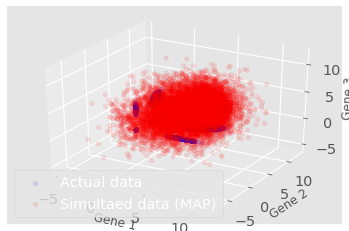

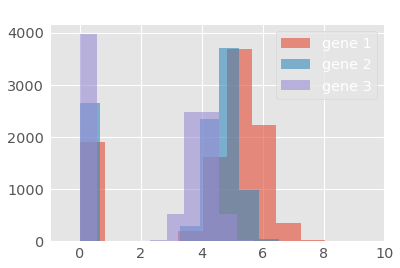

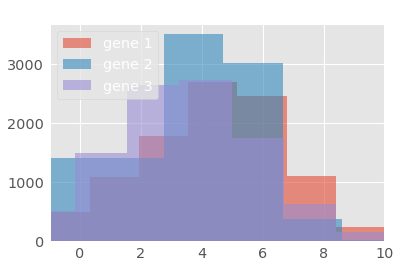

Actual mu:
 [[5.2817383]
 [4.696746 ]
 [3.9292154]] 
estimated mu:
 [[5.3373713]
 [4.7369914]
 [3.992536 ]]

Actual sigma
:  [[0.43924248]
 [0.22325848]
 [0.33332384]] 
estimated sigma:
 [[ 1.2490029]
 [-1.1437542]
 [ 2.1623173]]

Actual A:
 [[ 0.3126411   0.40084684]
 [ 0.23827624  0.3138989 ]
 [-0.12152314  0.257792  ]] 
estimated A:
 [[3.5478086 0.6712243]
 [1.1132133 5.2799664]
 [1.0480353 1.7458879]]


In [83]:
_, _, _, _, y_generated_base = model_1.sample(value=(sigma, z, A, mu, None))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_train[0,:],y_train[1,:],y_train[2,:], label='Actual data', color='blue', alpha=0.1)
ax.scatter(y_generated_base[0,:],y_generated_base[1,:],y_generated_base[2,:], label='Simultaed data (MAP)', color='red', alpha=0.1)
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

plt.hist(y_train[0, :], label='gene 1', alpha=0.6)
plt.hist(y_train[1, :], label='gene 2', alpha=0.6)
plt.hist(y_train[2, :], label='gene 3', alpha=0.6)
title = plt.title('Actual data')
plt.xlim((-1,10))
plt.setp(title, color='white')
plt.legend()
plt.show()

plt.hist(y_generated_base[0, :], label='gene 1', alpha=0.6)
plt.hist(y_generated_base[1, :], label='gene 2', alpha=0.6)
plt.hist(y_generated_base[2, :], label='gene 3', alpha=0.6)
title = plt.title('Simulated data (MAP)')
plt.xlim((-1,10))
plt.setp(title, color='white')
plt.legend()
plt.show()
print('Actual mu:\n',actual_mu.numpy(), '\nestimated mu:\n', mu.numpy())
print()
print('Actual sigma\n: ',actual_sigma.numpy(), '\nestimated sigma:\n', sigma.numpy())
print()
print('Actual A:\n',actual_A.numpy(), '\nestimated A:\n', A.numpy())

The simulated data starts to look like our trainingset. Because optimalization of the zero-inflation parameter $\lambda$ has not yet been applied in the first step, the data is not yet entirely accurate. However, the modes of all distributions are relatively in place, even though the distributions are skewed towards zero, to account for the large occurence of zero-values. We can also generate data with the parameters that were just found and an initial guess of $\lambda$ of $0.1$. Allowing the zero-inflation to generate our simulated data gives more promising results.

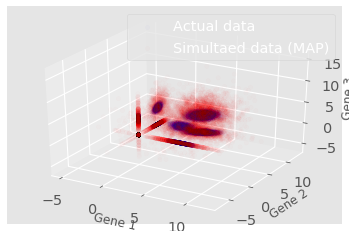

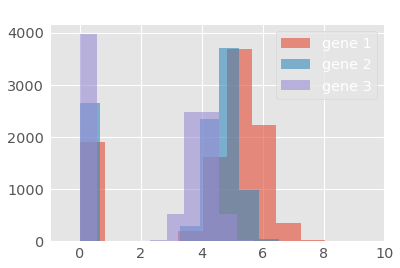

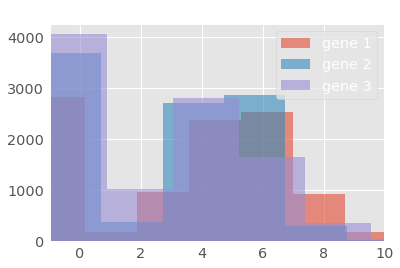

In [84]:
lamda = tf.Variable(0.1)

_, _, _, _, _, _, _, y_generated_lambda = model.sample(value=(sigma, lamda, z, A, mu, None, None, None))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_train[0,:],y_train[1,:],y_train[2,:], label='Actual data', color='blue', alpha=0.01)
ax.scatter(y_generated_lambda[0,:],y_generated_lambda[1,:],y_generated_lambda[2,:], label='Simultaed data (MAP)', color='red', alpha=0.01)
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

plt.hist(y_train[0, :], label='gene 1', alpha=0.6)
plt.hist(y_train[1, :], label='gene 2', alpha=0.6)
plt.hist(y_train[2, :], label='gene 3', alpha=0.6)
title = plt.title('Actual data')
plt.xlim((-1,10))
plt.setp(title, color='white')
plt.legend()
plt.show()

plt.hist(y_generated_lambda[0, :], label='gene 1', alpha=0.6)
plt.hist(y_generated_lambda[1, :], label='gene 2', alpha=0.6)
plt.hist(y_generated_lambda[2, :], label='gene 3', alpha=0.6)
title = plt.title('Simulated data (MAP)')
plt.xlim((-1,10))
plt.setp(title, color='white')
plt.legend()
plt.show()


 We can now optimize our model further by evaluating the complete model with zero-inflation in our optimalization. We use the newly found parameters as our initial guess. The original ZIFA model only evaluates $\lambda$, in this approach, however, results could only be achieved when $x$ and $h$ were estimated in between.

In [85]:
h = tf.Variable(1.0*np.ones([data_dim, num_datapoints]), dtype=tf.float32)
x = tf.identity(y_generated_lambda)

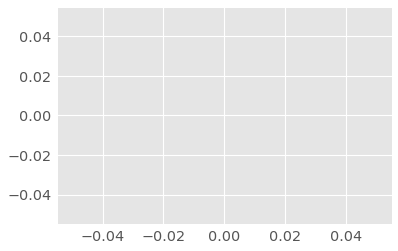

In [86]:
target_log_prob_fn = lambda sigma, lamda, z, A, mu, x, h: model.log_prob((sigma, lamda, z, A, mu, actual_x, actual_h, y_train))
losses = tfp.math.minimize(lambda: -target_log_prob_fn(sigma, lamda, z, A, mu, actual_x, actual_h),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=200)
plt.plot(losses)
plt.show()

Unfortunately, something goes wrong at this step. No valid numbers are returned and the parameters take invalid values, which is why the plot doesn't work most of the time. Still we have an output, plotted below. 

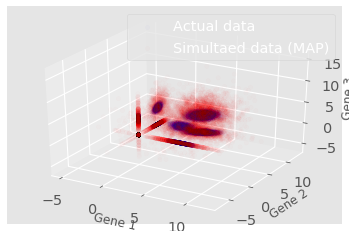

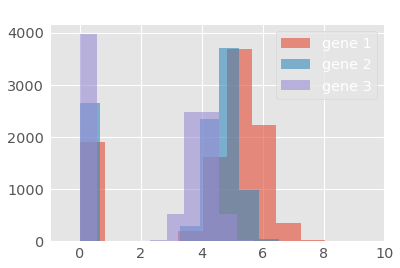

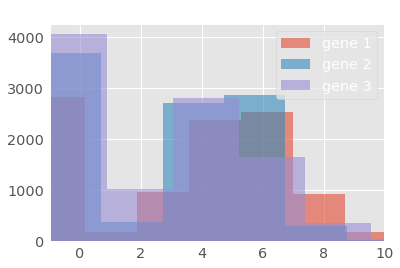

In [87]:
_, _, _, _, _, _, _, y_generated_final = model.sample(value=(sigma, lamda, z, A, mu, x, h, None))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_train[0,:],y_train[1,:],y_train[2,:], label='Actual data', color='blue', alpha=0.01)
ax.scatter(y_generated_final[0,:],y_generated_final[1,:],y_generated_final[2,:], label='Simultaed data (MAP)', color='red', alpha=0.01)
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

plt.hist(y_train[0, :], label='gene 1', alpha=0.6)
plt.hist(y_train[1, :], label='gene 2', alpha=0.6)
plt.hist(y_train[2, :], label='gene 3', alpha=0.6)
title = plt.title('Actual data')
plt.xlim((-1,10))
plt.setp(title, color='white')
plt.legend()
plt.show()

plt.hist(y_generated_final[0, :], label='gene 1', alpha=0.6)
plt.hist(y_generated_final[1, :], label='gene 2', alpha=0.6)
plt.hist(y_generated_final[2, :], label='gene 3', alpha=0.6)
title = plt.title('Simulated data (MAP)')
plt.xlim((-1,10))
plt.setp(title, color='white')
plt.legend()
plt.show()


In [88]:
print('Actual Lambda: ',actual_lambda.numpy(), ', estimated Lambda: ', lamda.numpy())
print()
print('Actual mu:\n',actual_mu.numpy(), '\nestimated mu:\n', mu.numpy())
print()
print('Actual sigma:\n',actual_sigma.numpy(), '\nestimated sigma:\n', sigma.numpy())
print()
print('Actual A:\n',actual_A.numpy(), '\nestimated A:\n', A.numpy())
print()
print('Actual z:\n',actual_z.numpy(), '\nestimated z:\n', z.numpy())

Actual Lambda:  0.061301555 , estimated Lambda:  0.061067678

Actual mu:
 [[5.2817383]
 [4.696746 ]
 [3.9292154]] 
estimated mu:
 [[5.3373713]
 [4.7369914]
 [3.992536 ]]

Actual sigma:
 [[0.43924248]
 [0.22325848]
 [0.33332384]] 
estimated sigma:
 [[ 0.38371256]
 [-0.27026916]
 [ 0.01089476]]

Actual A:
 [[ 0.3126411   0.40084684]
 [ 0.23827624  0.3138989 ]
 [-0.12152314  0.257792  ]] 
estimated A:
 [[ 1.7435864   0.3677506 ]
 [ 0.9564641   0.34343132]
 [-0.4459264   1.8560549 ]]

Actual z:
 [[-1.1051707  -0.05348021  1.767242   ...  1.2665544   0.60862905
  -1.246246  ]
 [ 0.79792523 -0.5711054  -0.49990666 ...  0.5140879  -0.54309946
   0.29672384]] 
estimated z:
 [[-0.552079   -0.26062673  0.4548175  ...  0.5365363  -0.22839361
  -0.08593515]
 [ 0.24152549 -0.11172895 -0.17387758 ... -0.07254179 -0.3506426
   0.13007961]]


Visually, the output values look very similar in both the histogram and the scatterplot. On inspection of the actual values of all parameters, we observe that $\lambda$ and $\mu$ tend to be estimated quite accurately and the value for $\sigma$ is usually not too far off either. $A$ and $z$, however, are usually found with different numbers than their actual values.

In [89]:
estimate_means = tf.einsum('ij,ki->kj',z,A)+mu
print(estimate_means)
actual_means = tf.einsum('ij,ki->kj',actual_z,actual_A)+actual_mu
print(actual_means)

tf.Tensor(
[[4.463595  4.841858  6.0664415 ... 6.2461915 4.8101983 5.235373 ]
 [4.291895  4.44934   5.1122932 ... 5.225256  4.3981194 4.699471 ]
 [4.6870074 3.9013813 3.4669945 ... 3.6186388 3.4435709 4.2722917]], shape=(3, 10000), dtype=float32)
tf.Tensor(
[[5.2560625 5.0360923 5.633865  ... 5.8837857 5.254321  5.011051 ]
 [4.683878  4.5047336 4.9609175 ... 5.1599073 4.6712894 4.492936 ]
 [4.269218  3.7884881 3.5855827 ... 3.9078276 3.7152462 4.157156 ]], shape=(3, 10000), dtype=float32)


The product of $A$ and $z$ remains similar. Most values deviate only slightly, and these deviations become less significant when $\mu$ is added. This results in our well-estimated guess of the final dataset $y$. The latent data, however, is not accurately estimated. This is a pity, since achieving the latent data was our means of dimensionality reduction. The [original TFP tutorial for PPCA's](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_PCA.ipynb) was revisisted for inspiration on how to fix this, but on second sight, it turned out that even TFP's own tutorials do not recreate the same factor loadings and latent data matrix.

Since the final results of $x$ can still be recreated, one might wonder if the latent data $z$ still holds the same significance: Have our latent dimensions lost their interpretation? Is this the result of overfitting, of have we simply arrived at another local optimum? Are the newly found latent axes a better optimum and should they be considered as more accurate latent dimensions than the original latent axes? Or does this alternative latent data give rise to new errors later in the process? In the next section we will try to answer these questions.

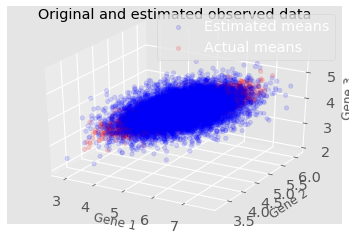

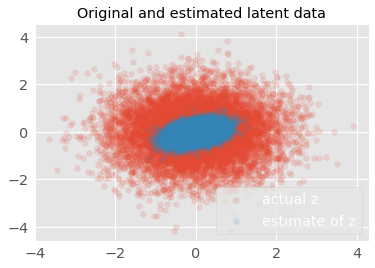

In [90]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(estimate_means[0,:],estimate_means[1,:],estimate_means[2,:], label='Estimated means', color='blue', alpha=0.15)
ax.scatter(actual_means[0,:],actual_means[1,:],actual_means[2,:], label='Actual means', color='red', alpha=0.15)
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
title = plt.title('Original and estimated observed data')
plt.setp(title, color='black') 
plt.legend()
plt.show()


plt.scatter(actual_z[0,:], actual_z[1,:], label='actual z', alpha=0.15)
plt.scatter(z[0,:], z[1,:], label='estimate of z', alpha=0.15)
title = plt.title('Original and estimated latent data')
plt.setp(title, color='black') 
plt.legend()
plt.show()

## Experiments regarding the alternative latent dataset

In the following experiment, we initialize the values of $A$, $\sigma$, $z$, $h$ and $x$ with their actual values. If the process gets hold of an alternate direction due to local minima, we should find the correct values when initializing with the correct solution. We can directly use the full model, since we don't need to approach an estimate for $A$ or $z$ beforehand this time.

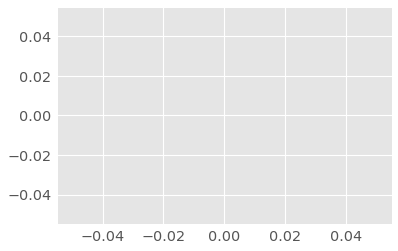

In [91]:
mu = tf.expand_dims(tf.Variable(np.float32(np.sum(y_train, axis=1)/np.sum(y_train!=0, axis=1))),1)
sigma = tf.Variable(actual_sigma)
A = tf.Variable(tf.identity(actual_A))
z = tf.Variable(tf.identity(actual_z))
h = tf.Variable(tf.identity(actual_h))
x = tf.Variable(tf.identity(actual_x))

target_log_prob_fn = lambda sigma, lamda, z, A, mu, x, h: model.log_prob((sigma, lamda, z, A, mu, actual_x, actual_h, y_train))
losses = tfp.math.minimize(lambda: -target_log_prob_fn(sigma, lamda, z, A, mu, actual_x, actual_h),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=200)
plt.plot(losses)
plt.show()

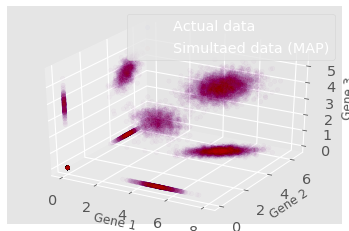

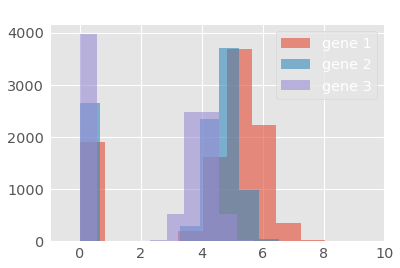

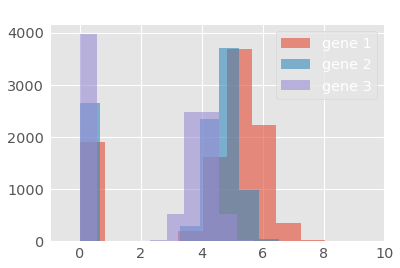

In [92]:
_, _, _, _, _, _, _, y_generated_final = model.sample(value=(sigma, lamda, z, A, mu, x, h, None))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_train[0,:],y_train[1,:],y_train[2,:], label='Actual data', color='blue', alpha=0.01)
ax.scatter(y_generated_final[0,:],y_generated_final[1,:],y_generated_final[2,:], label='Simultaed data (MAP)', color='red', alpha=0.01)
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

plt.hist(y_train[0, :], label='gene 1', alpha=0.6)
plt.hist(y_train[1, :], label='gene 2', alpha=0.6)
plt.hist(y_train[2, :], label='gene 3', alpha=0.6)
title = plt.title('Actual data')
plt.xlim((-1,10))
plt.setp(title, color='white')
plt.legend()
plt.show()

plt.hist(y_generated_final[0, :], label='gene 1', alpha=0.6)
plt.hist(y_generated_final[1, :], label='gene 2', alpha=0.6)
plt.hist(y_generated_final[2, :], label='gene 3', alpha=0.6)
title = plt.title('Simulated data (MAP)')
plt.xlim((-1,10))
plt.setp(title, color='white')
plt.legend()
plt.show()


In [93]:
print('Actual Lambda: ',actual_lambda.numpy(), ', estimated Lambda: ', lamda.numpy())
print()
print('Actual mu:\n',actual_mu.numpy(), '\nestimated mu:\n', mu.numpy())
print()
print('Actual sigma:\n',actual_sigma.numpy(), '\nestimated sigma:\n', sigma.numpy())
print()
print('Actual A:\n',actual_A.numpy(), '\nestimated A:\n', A.numpy())
print()
print('Actual z:\n',actual_z.numpy(), '\nestimated z:\n', z.numpy())

Actual Lambda:  0.061301555 , estimated Lambda:  0.061063346

Actual mu:
 [[5.2817383]
 [4.696746 ]
 [3.9292154]] 
estimated mu:
 [[5.3373713]
 [4.7369914]
 [3.992536 ]]

Actual sigma:
 [[0.43924248]
 [0.22325848]
 [0.33332384]] 
estimated sigma:
 [[0.5115833]
 [0.5782443]
 [0.1946974]]

Actual A:
 [[ 0.3126411   0.40084684]
 [ 0.23827624  0.3138989 ]
 [-0.12152314  0.257792  ]] 
estimated A:
 [[ 0.52936673  0.26818413]
 [-0.07486444  0.7526823 ]
 [-0.44109014  0.5952002 ]]

Actual z:
 [[-1.1051707  -0.05348021  1.767242   ...  1.2665544   0.60862905
  -1.246246  ]
 [ 0.79792523 -0.5711054  -0.49990666 ...  0.5140879  -0.54309946
   0.29672384]] 
estimated z:
 [[-0.63931113 -0.1659713   0.5577275  ...  0.65497285 -0.18542813
  -0.3362743 ]
 [ 0.57779324 -0.3387304  -0.33599144 ...  0.01115114 -1.0125363
   0.08807156]]


Again, the optimalization finds new values that differ from the initially given values. As shown before, the log_prob() function of the complete model is not yet entirely functional, so we can not evaluate whether these new values actually have a higher probability of being true. The log_prob() function does work however for the first step of the model. Strangely, when evaluating the values of $\sigma$, $A$, $z$ and $\mu$, we see a decrease from a real number with the actual values to a value of $-\infty$ when plugging in the newly computed values. It is not sure why the optimization algorithm decreases the probability.

In [94]:
mu = tf.expand_dims(tf.Variable(np.float32(np.sum(y_train, axis=1)/np.sum(y_train!=0, axis=1))),1)
sigma = tf.Variable(actual_sigma)
A = tf.Variable(tf.identity(actual_A))
z = tf.Variable(tf.identity(actual_z))

target_log_prob_fn = lambda sigma, z, A, mu: model_1.log_prob((sigma, z, A, mu, y_train))
losses = tfp.math.minimize(lambda: -target_log_prob_fn(sigma, z, A, mu),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=1000)

In [95]:
print('log prob of given values: ',model_1.log_prob((actual_sigma, actual_z, actual_A, actual_mu, actual_x)))
print('log prob of computed values: ',model_1.log_prob((sigma, z, A, mu, actual_x)))

log prob of given values:  tf.Tensor([-36650.746 -36648.047 -36649.902], shape=(3,), dtype=float32)
log prob of computed values:  tf.Tensor([nan nan nan], shape=(3,), dtype=float32)


# Experimental test zone, under construction, not pretty

In [16]:
Root = tfd.JointDistributionCoroutine.Root
def ZIFA_step1(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    
    # We start by generating a sigma^2
    sigma_sqrd = yield Root(tfd.Independent(
        tfd.Normal(loc=stddv_datapoints, scale=0.15, name='sigma')))
    
    # Then the latent data z
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=1.0*tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))

    # For A we first define the boundaries for its uniform distribution and then A itself. The boundaries are created outside the function,
    # lower in this cell
    A = yield Root(tfd.Independent(
        tfd.Uniform(low=low_A, high=high_A, name='A')))
    
    # Here comes mu
    mu = yield Root(tfd.Independent(
        tfd.Uniform(low=2.0*tf.ones([data_dim,1]),
                 high=6.5*tf.ones([data_dim,1]),
                 name="mu"), reinterpreted_batch_ndims=1))
    
    # Tensorflows einsum() function is used to take the products of A and the individual columns of z, which is used to obtain the means of x
    x = yield Root(tfd.Independent(tfd.Normal(
        loc=tf.einsum('ij,ki->kj',z,A)+mu,
        scale=sigma_sqrd,
        name="x"), reinterpreted_batch_ndims=2))
    
# The boundaries for the uniform distribution of A
low_A = np.float32(-0.5*np.ones([data_dim, latent_dim]))
np.fill_diagonal(low_A,0.9*stddv_datapoints)
high_A = np.float32(0.5*np.ones([data_dim, latent_dim]))
np.fill_diagonal(high_A,1.1*stddv_datapoints)

In [17]:
def probabilistic_pca_mu(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    w = yield Root(tfd.Independent(
        tfd.Uniform(low=low_A, high=high_A, name='A')))
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=1.0*tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))
    mu = yield Root(tfd.Independent(
        tfd.Uniform(low=2.0*tf.ones([data_dim,1]),
                 high=6.5*tf.ones([data_dim,1]),
                 name="mu"), reinterpreted_batch_ndims=1))
    x_mu = yield tfd.Independent(tfd.Normal(
        loc=tf.matmul(w, z)+mu,
        scale=stddv_datapoints,
        name="x_mu"), reinterpreted_batch_ndims=2)
    

concrete_ppca_model_mu = functools.partial(probabilistic_pca_mu,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_samples_nozero,
    stddv_datapoints=stddv_datapoints)

model_mu = tfd.JointDistributionCoroutine(concrete_ppca_model_mu)

NameError: name 'num_samples_nozero' is not defined

And we generate some data. Note the Zero inflation as depicted in the three histograms representing three genes.

In [ ]:
actual_sigma, actual_lambda, actual_z, actual_A, actual_mu, actual_x, actual_h, y_train = model.sample()
print('Lambda: ', actual_lambda.numpy())
print('mu:', actual_mu.numpy())

plt.scatter(actual_z[0,:], actual_z[1,:], alpha=0.3)
title = plt.title('Latent data')
plt.setp(title, color='black') 
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_train[0,:],y_train[1,:],y_train[2,:], alpha=0.3)
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

plt.hist(y_train[0, :], label='gene 1', alpha=0.6)
plt.hist(y_train[1, :], label='gene 2', alpha=0.6)
plt.hist(y_train[2, :], label='gene 3', alpha=0.6)
title = plt.title('Histogram of the observed data')
plt.setp(title, color='black')
plt.legend()
plt.show()

In [ ]:
mask = []
for i in range(num_datapoints):
    if np.all(y_train[:,i])!=0:
        mask.append(True)
    else:
        mask.append(False)

In [ ]:
y_train_nozeroes = tf.convert_to_tensor(np.array(y_train)[:,mask])
num_samples_nozero = len(y_train_nozeroes[0])
print(num_samples_nozero, 'samples found without dropout.')

In [ ]:
mu = tf.expand_dims(tf.Variable(np.float32(np.mean(y_train_nozeroes, axis=1))),1)
print(mu)

In [ ]:
concrete_ZIFA_model = functools.partial(ZIFA_step1,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_samples_nozero,
    stddv_datapoints=stddv_datapoints)

model_step1 = tfd.JointDistributionCoroutine(concrete_ZIFA_model)

In [ ]:
sigma = tf.Variable(0.3)
A_np = np.float32(np.zeros([data_dim, latent_dim]))
np.fill_diagonal(A_np,stddv_datapoints)
A = tf.Variable(A_np)
z = tf.Variable(np.zeros([latent_dim, num_samples_nozero]), dtype=tf.float32)

target_log_prob_fn = lambda sigma, z, A, mu: model_step1.log_prob((sigma, z, A, mu, y_train_nozeroes))
losses = tfp.math.minimize(lambda: -target_log_prob_fn(sigma, z, A, mu),
                           optimizer=tf.optimizers.Adam(learning_rate=0.04),
                           num_steps=1500)
plt.plot(losses)
plt.title('Loss function over iterations')
plt.show()

In [ ]:
_, _, _, _, y_generated_final = model_step1.sample(value=(sigma, z, A, mu, None))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_train[0,:],y_train[1,:],y_train[2,:], label='Actual data', color='red', alpha=0.01)
ax.scatter(y_generated_final[0,:],y_generated_final[1,:],y_generated_final[2,:], label='Simultaed data (MAP)', color='blue', alpha=0.01)
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

plt.hist(y_train[0, :], label='gene 1', alpha=0.6)
plt.hist(y_train[1, :], label='gene 2', alpha=0.6)
plt.hist(y_train[2, :], label='gene 3', alpha=0.6)
title = plt.title('Actual data')
plt.xlim((-1,10))
plt.setp(title, color='white')
plt.legend()
plt.show()

plt.hist(y_generated_final[0, :], label='gene 1', alpha=0.6)
plt.hist(y_generated_final[1, :], label='gene 2', alpha=0.6)
plt.hist(y_generated_final[2, :], label='gene 3', alpha=0.6)
title = plt.title('Simulated data (MAP)')
plt.xlim((-1,10))
plt.setp(title, color='white')
plt.legend()
plt.show()



In [ ]:
concrete_ppca_model_mu = functools.partial(probabilistic_pca_mu,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_samples_nozero,
    stddv_datapoints=stddv_datapoints)

model_mu = tfd.JointDistributionCoroutine(concrete_ppca_model_mu)

sigma = tf.Variable(0.3)
A_np = np.float32(np.zeros([data_dim, latent_dim]))
np.fill_diagonal(A_np,stddv_datapoints)
A = tf.Variable(A_np)
z = tf.Variable(np.zeros([latent_dim, num_samples_nozero]), dtype=tf.float32)

target_log_prob_fn_mu = lambda A, z, mu: model_mu.log_prob((A, z, mu, y_train_nozeroes))
losses_mu = tfp.math.minimize(lambda: -target_log_prob_fn_mu(A, z, mu),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=1500)
plt.plot(losses)
plt.show()

In [ ]:
print(A, actual_A)
print(mu, actual_mu)
print(z.numpy(), actual_z)

In [ ]:
_, _, _, y_generated_final = model_mu.sample(value=(A, z, mu, None))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_train[0,:],y_train[1,:],y_train[2,:], label='Actual data', color='red', alpha=0.01)
ax.scatter(y_generated_final[0,:],y_generated_final[1,:],y_generated_final[2,:], label='Simultaed data (MAP)', color='blue', alpha=0.01)
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

plt.hist(y_train[0, :], label='gene 1', alpha=0.6)
plt.hist(y_train[1, :], label='gene 2', alpha=0.6)
plt.hist(y_train[2, :], label='gene 3', alpha=0.6)
title = plt.title('Actual data')
plt.xlim((-1,10))
plt.setp(title, color='white')
plt.legend()
plt.show()

plt.hist(y_generated_final[0, :], label='gene 1', alpha=0.6)
plt.hist(y_generated_final[1, :], label='gene 2', alpha=0.6)
plt.hist(y_generated_final[2, :], label='gene 3', alpha=0.6)
title = plt.title('Simulated data (MAP)')
plt.xlim((-1,10))
plt.setp(title, color='white')
plt.legend()
plt.show()



In [ ]:
def probabilistic_pca_mu(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    w = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
                 scale=3.0 * tf.ones([data_dim, latent_dim]),
                 name="w"), reinterpreted_batch_ndims=2))
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=2.0*tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))
    mu = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([data_dim,1]),
                 scale=5.0*tf.ones([data_dim,1]),
                 name="mu"), reinterpreted_batch_ndims=1))
    x_mu = yield tfd.Independent(tfd.Normal(
        loc=tf.matmul(w, z)+mu,
        scale=stddv_datapoints,
        name="x_mu"), reinterpreted_batch_ndims=2)
    

concrete_ppca_model_mu = functools.partial(probabilistic_pca_mu,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model_mu = tfd.JointDistributionCoroutine(concrete_ppca_model_mu)

In [ ]:
actual_w, actual_z, actual_mu, x_mu_train = model_mu.sample()

In [ ]:
w_mu = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z_mu = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)
mu_mu = tf.expand_dims(tf.reduce_mean(x_mu_train, 1),1)

target_log_prob_fn_mu = lambda w_mu, z_mu, mu_mu: model_mu.log_prob((w_mu, z_mu, mu_mu, x_mu_train))
losses_mu = tfp.math.minimize(lambda: -target_log_prob_fn_mu(w_mu, z_mu, mu_mu),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=300)
plt.plot(losses_mu[:,0], label='complete model', color='red')
plt.legend()
plt.show()

In [ ]:
print("MAP-estimated axes:")
print('actual W: ',actual_w)
print('Estimated W: ',w_mu)
print()
print('actual Z: ',actual_z)
print('Estimated Z: ',z_mu)
print()
print('actual mu: ',actual_mu)
print('Estimated mu: ',mu_mu)

_, _, _, x_generated_mu = model_mu.sample(value=(w_mu, z_mu, mu_mu, None))
plt.legend()
plt.scatter(x_mu_train[0, :], x_mu_train[1, :], x_mu_train[2, :], color='blue', alpha=0.01, label='Actual data')
plt.scatter(x_generated_mu[0, :], x_generated_mu[1, :], x_generated_mu[2, :], color='red', alpha=0.1, label='Simulated data (MAP)')

plt.title('Model with and without mu')
# plt.axis([-20, 20, -20, 20])
plt.show()